In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pathlib
import celltypist
from celltypist import models
params = {
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 10,
    'font.family': "Arial",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 100
   }

mpl.rcParams.update(params)

sns.set_style("ticks")
sns.set_context(context='paper')
savefig_args = {"dpi": 300, "bbox_inches": "tight", "pad_inches": 0, "transparent": True}
mpl.rc('savefig', dpi=300)
output_dir='../../figures/QCandAnnotation'
pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)
output_suffix = ""
output_formats = [".png", ".svg"]
sc.settings.figdir = output_dir
sc.set_figure_params(format='pdf', transparent=True,)
def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 20) 
pd.set_option('display.width', 100)
%load_ext autoreload
%autoreload 2


def recluster(adata, batch_correct, sample_uid = 'sample_uid'):
    sc.pp.pca(adata)
    if batch_correct == True:
        sc.external.pp.bbknn(adata, batch_key=sample_uid)
    else:
        sc.pp.neighbors(adata, n_neighbors=10)
    sc.tl.umap(adata)
    sc.tl.leiden(adata, resolution=0.2)
    sc.pl.umap(adata, color = sample_uid)
    return adata

%run ../../scripts/plotting_helper.py

## Load Data

In [2]:
adata = sc.read_h5ad('/home/michaelswift/repos/shared_data/BCD2/scirpy_processed_cellbender.h5ad')

In [3]:
adata.obs

multi_chain                                       extra_chains has_ir is_cell  \
AAACCTGAGAAACCGC-1        None                                                 []  False    None   
AAACCTGAGAAGATTC-1       False                                                 []   True    True   
AAACCTGAGAGGTACC-1       False  [{"c_call": "IGLC1", "cdr1": null, "cdr1_aa": ...   True    True   
AAACCTGAGAGTACAT-1        None                                                 []  False    None   
AAACCTGAGATAGGAG-1        None                                                 []  False    None   
...                        ...                                                ...    ...     ...   
TTTGTCATCGCTGATA-1       False  [{"c_call": "IGHD", "cdr1": null, "cdr1_aa": n...   True    True   
TTTGTCATCGGACAAG-1        None                                                 []  False    None   
TTTGTCATCGTGACAT-1        None                                                 []  False    None   
TTTGTCATCTCGTATT-1        None                                                 []  False    None   
TTTGTCATCTGTGCAA-1        None                                                 []  False    None   

                   high_confidence IR_VJ_1_c_call IR_VJ_2_c_call IR_VDJ_1_c_call IR_VDJ_2_c_call  \
AAACCTGAGAAACCGC-1            None            NaN            NaN             NaN             NaN   
AAACCTGAGAAGATTC-1            True           IGKC            NaN            IGHM             NaN   
AAACCTGAGAGGTACC-1            True           IGKC            NaN            IGHM             NaN   
AAACCTGAGAGTACAT-1            None            NaN            NaN             NaN             NaN   
AAACCTGAGATAGGAG-1            None            NaN            NaN             NaN             NaN   
...                            ...            ...            ...             ...             ...   
TTTGTCATCGCTGATA-1            True           IGKC            NaN            IGHM             NaN   
TTTGTCATCGGACAAG-1            None            NaN            NaN             NaN             NaN   
TTTGTCATCGTGACAT-1            None            NaN            NaN             NaN             NaN   
TTTGTCATCTCGTATT-1            None            NaN            NaN             NaN             NaN   
TTTGTCATCTGTGCAA-1            None            NaN            NaN             NaN             NaN   

                                            IR_VJ_1_cdr1  ...  mutation_status  \
AAACCTGAGAAACCGC-1                                   NaN  ...              NaN   
AAACCTGAGAAGATTC-1     CGGGCAAGTCAGGGCATTAGAAATGATTTAGGC  ...         germline   
AAACCTGAGAGGTACC-1  AGGGCCAGTCAGAGTGTTAGCAGCAGCTACTTAGCC  ...         germline   
AAACCTGAGAGTACAT-1                                   NaN  ...              NaN   
AAACCTGAGATAGGAG-1                                   NaN  ...         germline   
...                                                  ...  ...              ...   
TTTGTCATCGCTGATA-1  AGGGCCAGTCAGACTGTAAACAGCTTCTACTTAGCC  ...  heavily mutated   
TTTGTCATCGGACAAG-1                                   NaN  ...              NaN   
TTTGTCATCGTGACAT-1                                   NaN  ...              NaN   
TTTGTCATCTCGTATT-1                                   NaN  ...              NaN   
TTTGTCATCTGTGCAA-1                                   NaN  ...              NaN   

                   simple_mutation_status parsed_sample_uid n_genes n_counts receptor_type  \
AAACCTGAGAAACCGC-1                    NaN         ir_object    1884   5339.0         no IR   
AAACCTGAGAAGATTC-1               germline         ir_object    1614   3876.0           BCR   
AAACCTGAGAGGTACC-1               germline         ir_object    5995  26807.0           BCR   
AAACCTGAGAGTACAT-1                    NaN         ir_object    2343   6672.0         no IR   
AAACCTGAGATAGGAG-1               germline         ir_object    1721   4095.0         no IR   
...                                   ...               ...     ... 

# adata based Quality Control And Filtering

## Preprocessing Normalize - Transform - Cluster

In [4]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 36 glyphs before
Glyph names: ['.notdef', '.null', 'B', 'C', 'I', 'K', 'L', 'M', 'N', 'P', 'T', 'a', 'b', 'c', 'e', 'eight', 'four', 'g', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 's', 'seven', 'six', 'space', 't', 'two', 'u', 'underscore', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 23, 25, 26, 27, 28, 37, 38, 44, 46, 47, 48, 49, 51, 55, 66, 68, 69, 70, 72, 74, 79, 80, 81, 82, 83, 86, 87, 88, 92]
Closed glyph list over 'GSUB': 36 glyphs after
Glyph names: ['.notdef', '.null', 'B', 'C', 'I', 'K', 'L', 'M', 'N', 'P', 'T', 'a', 'b', 'c', 'e', 'eight', 'four', 'g', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 's', 'seven', 'six', 'space', 't', 'two', 'u', 'underscore', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 23, 25, 26, 27, 28, 37, 38, 44, 46, 4

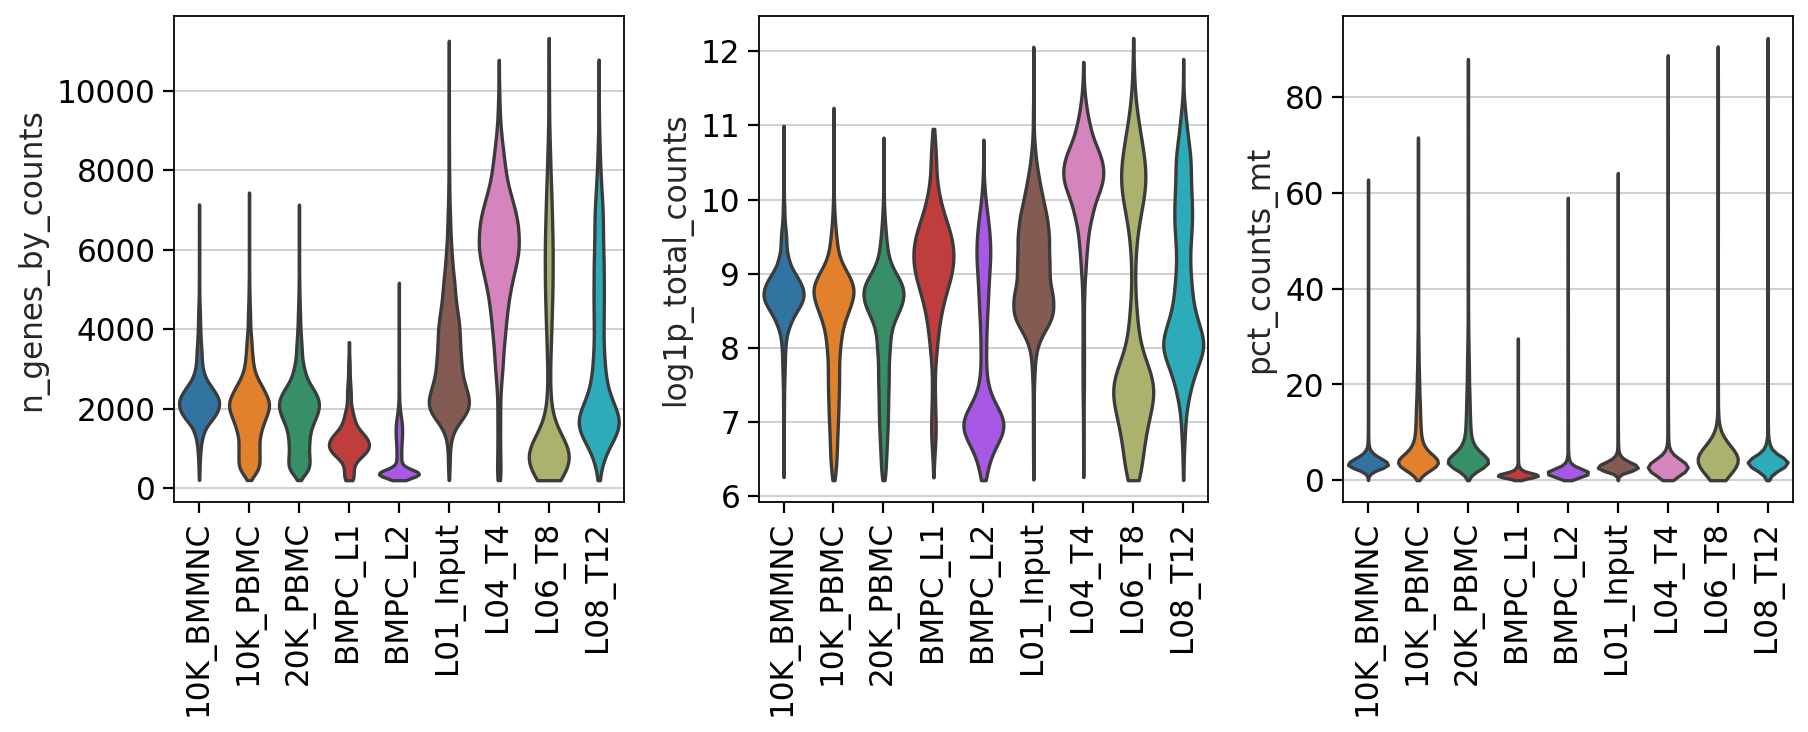

In [5]:
sc.pl.violin(adata, ['n_genes_by_counts', 'log1p_total_counts', 'pct_counts_mt'], groupby='sample_uid', stripplot=False,
              multi_panel=True, rotation = 90, save = "_qc_pre_filter")

In [6]:
sc.pp.filter_cells(adata, min_genes=500)

In [7]:
sc.pp.filter_cells(adata, min_counts=2000)
sc.pp.filter_cells(adata, max_counts=100000)
# filter mt 
adata = adata[adata.obs.pct_counts_mt < 10]

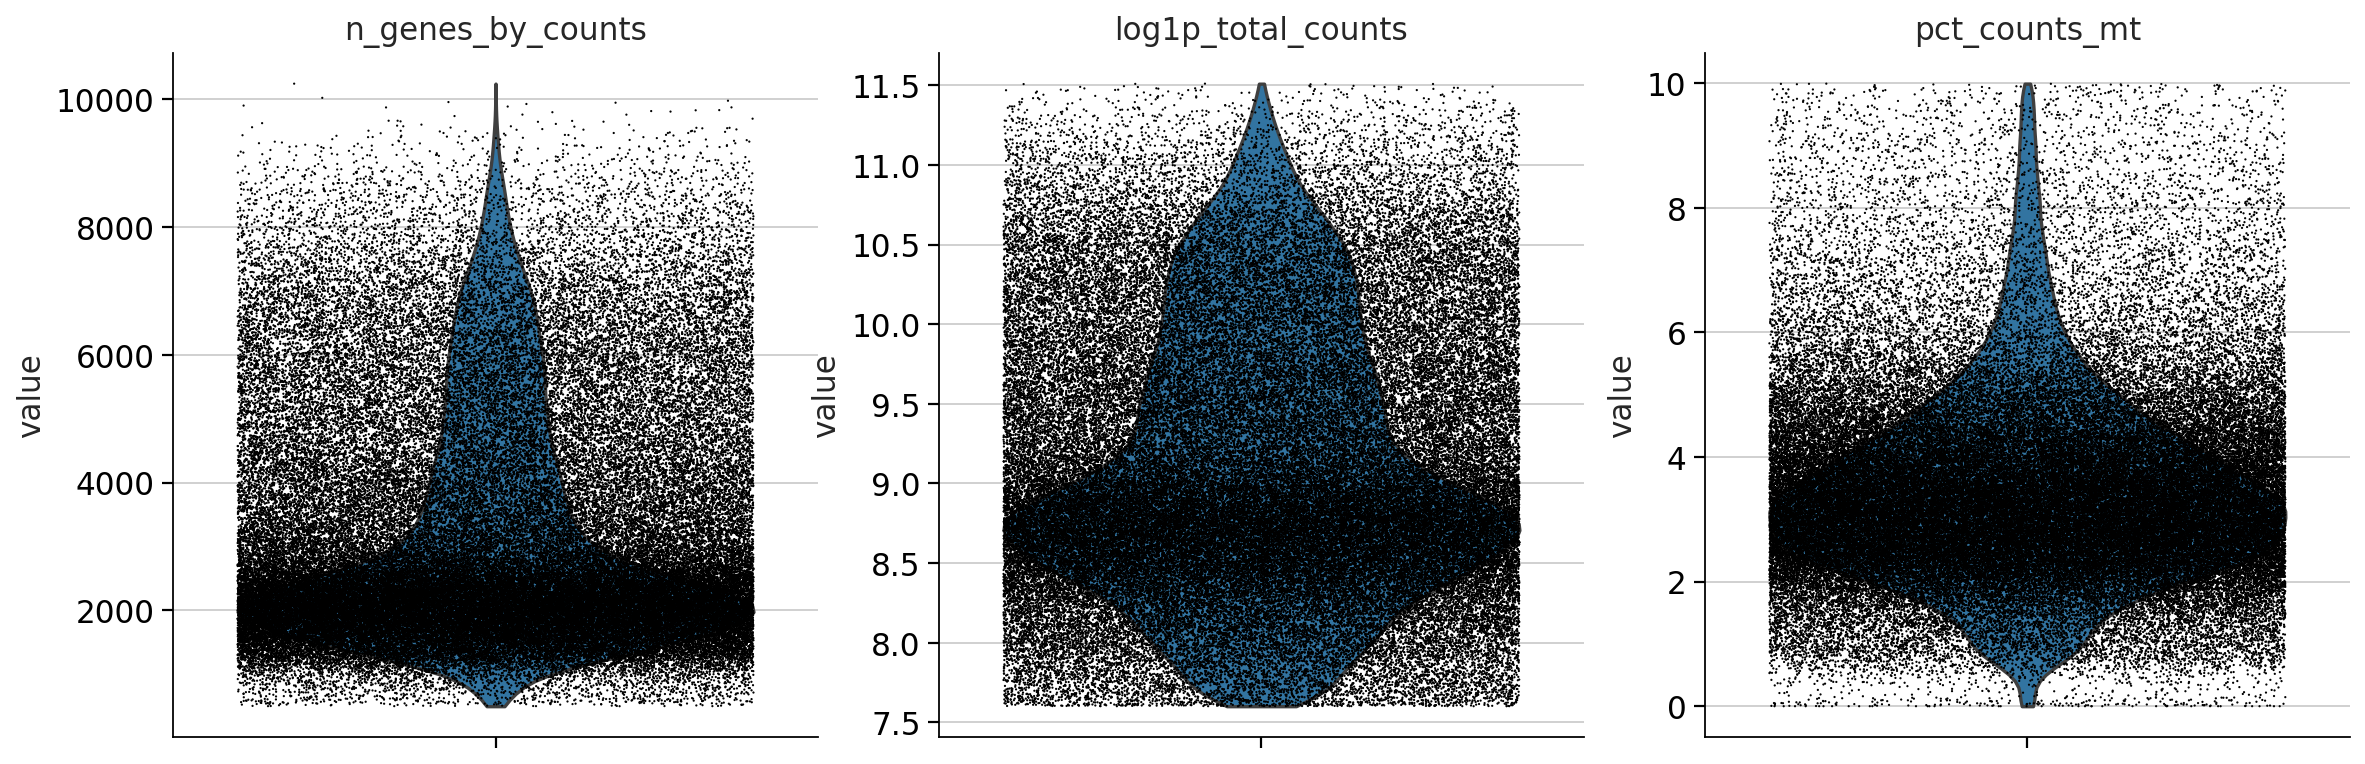

In [8]:
sc.pl.violin(adata, ['n_genes_by_counts', 'log1p_total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 35 glyphs before
Glyph names: ['.notdef', '.null', 'B', 'C', 'I', 'K', 'L', 'M', 'N', 'P', 'T', 'a', 'b', 'c', 'e', 'eight', 'four', 'g', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 's', 'six', 'space', 't', 'two', 'u', 'underscore', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 23, 25, 27, 28, 37, 38, 44, 46, 47, 48, 49, 51, 55, 66, 68, 69, 70, 72, 74, 79, 80, 81, 82, 83, 86, 87, 88, 92]
Closed glyph list over 'GSUB': 35 glyphs after
Glyph names: ['.notdef', '.null', 'B', 'C', 'I', 'K', 'L', 'M', 'N', 'P', 'T', 'a', 'b', 'c', 'e', 'eight', 'four', 'g', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 's', 'six', 'space', 't', 'two', 'u', 'underscore', 'y', 'zero']
Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 23, 25, 27, 28, 37, 38, 44, 46, 47, 48, 49, 51, 55, 66, 68,

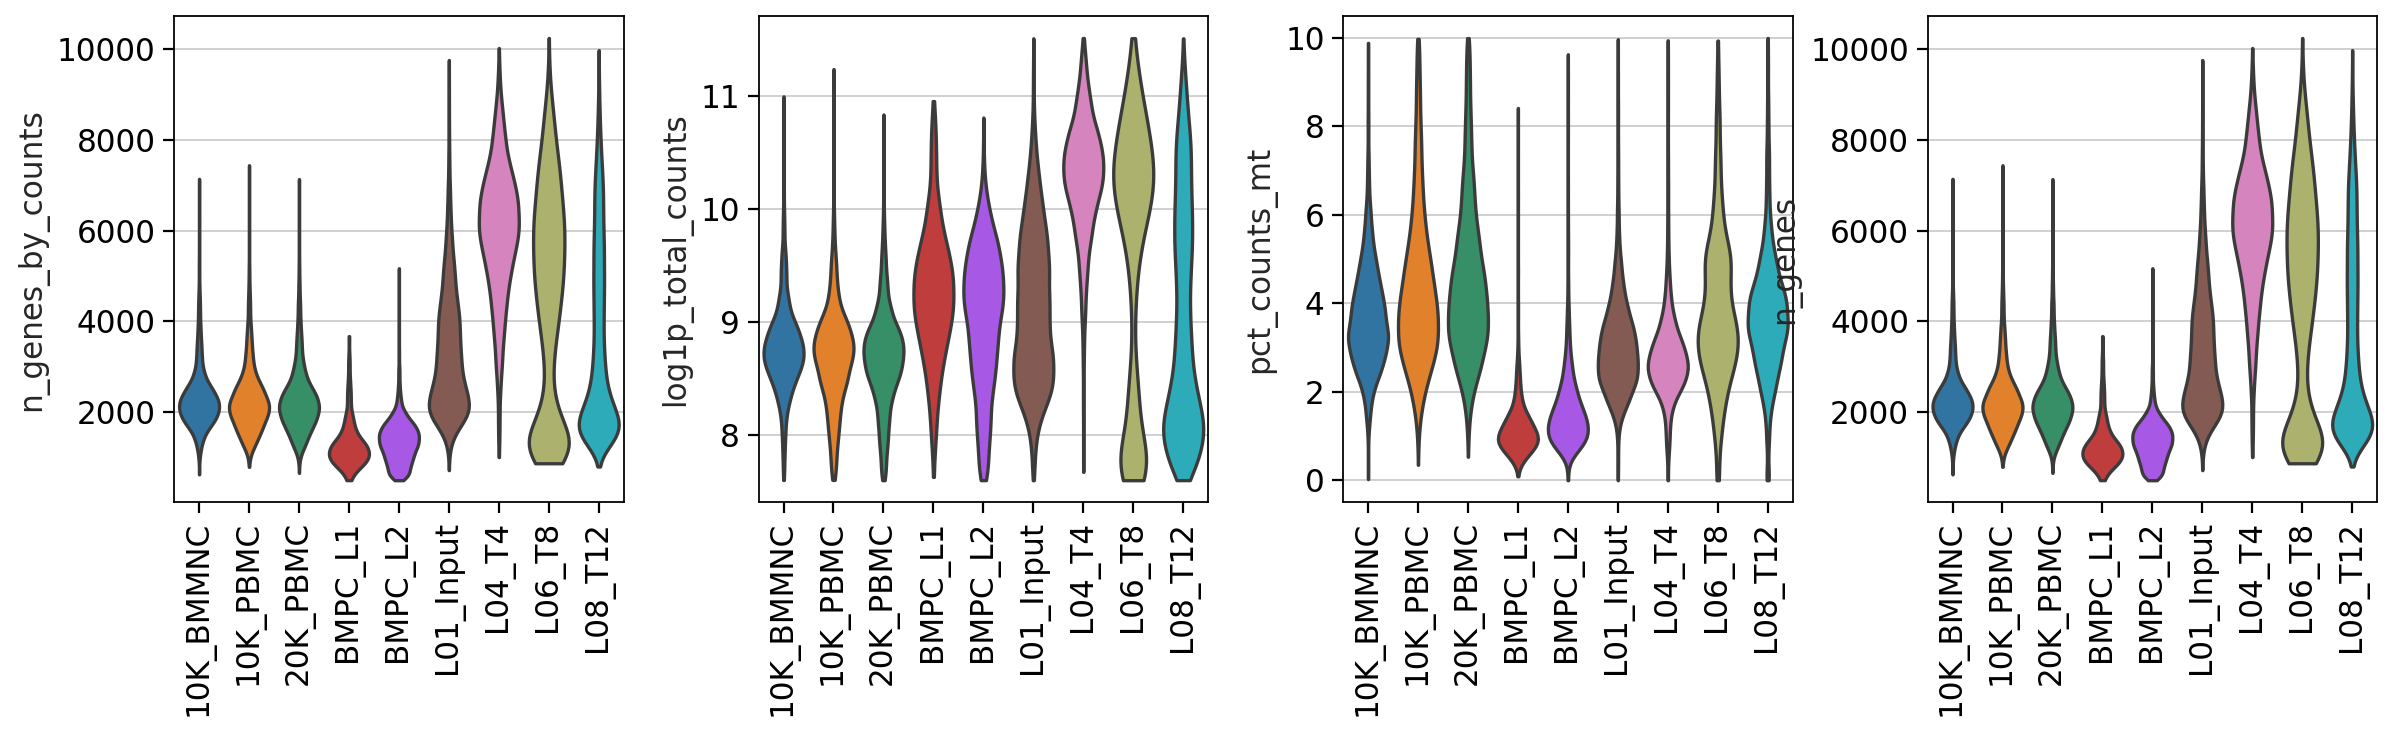

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'log1p_total_counts', 'pct_counts_mt', "n_genes"], groupby='sample_uid', stripplot=False,
              multi_panel=True, rotation = 90, save = "_quality_metrics_post_filter")

# Write out the Data for seqclone and CoSpar:
adata.write_h5ad('forseqclone.h5ad')
BM = adata[adata.obs.sample_id == 'BM CD138+']
BM.write_h5ad('BMforseqclone.h5ad')

bcells = sc.read_h5ad("../../h5ad_objects/bcells.h5ad")
cells = bcells.obs.index
# just B cells
bcells = adata[adata.obs.index.isin(cells)]
bcells.write_h5ad('../../h5ad_objects/bcells_raw.h5ad')

In [10]:
adata.layers['counts'] = adata.X

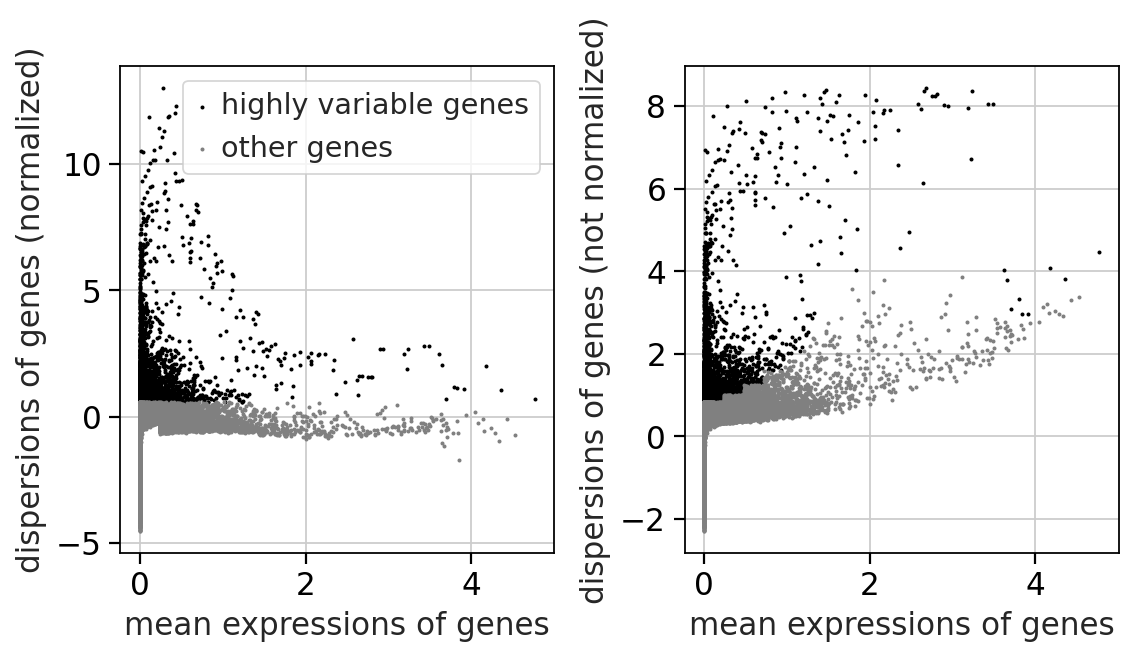

In [11]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata, base = 2, chunk_size=10000 )
sc.pp.highly_variable_genes(adata, n_top_genes=4000)
sc.pl.highly_variable_genes(adata)
adata.raw = adata
sc.pp.scale(adata, max_value = 10)

In [12]:
# remove IGH and IGL variable genes from highly variable genes for clustering analysis 
adata.var.loc[adata.var.index.str.contains("IGHV|IGLV|IGKV"), 'highly_variable'] = False

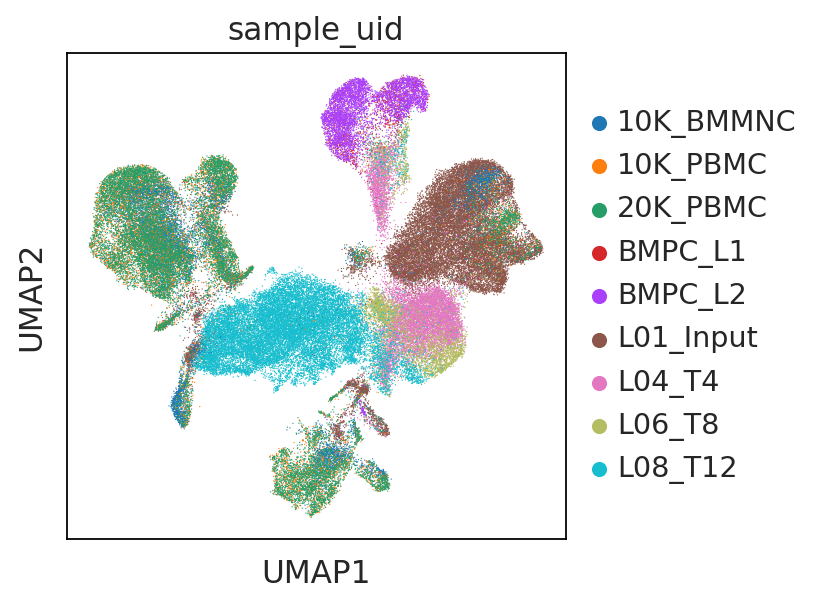

In [13]:
adata = recluster(adata, batch_correct=True)

# Cell Typist Based Classification 

In [14]:
adata.obs_names_make_unique()

In [15]:
# rename lane for interpretability:
rename_dict = {'10K_BMMNC' : 'BMMNC', '10K_PBMC': 'PBMC',
               '20K_PBMC': 'PBMC' , "BMPC_L1" : "BM CD138+", "BMPC_L2": "BM CD138+",
               'L01_Input': 'Day 0', 'L04_T4': "Day 4", "L06_T8":"Day 8", "L08_T12" : "Day 12"}   



In [16]:
adata.obs['sample_id'] = adata.obs.sample_uid.map(rename_dict)

In [17]:

anno_1 = "celltypist_all"
#Download all the available models.
models.download_models()
#Provide the input as an `AnnData`.
predictions = celltypist.annotate(adata, model = 'Immune_All_Low.pkl', majority_voting=True)
# Celltypist Annotations to bcells object
adata.obs[anno_1] = predictions.predicted_labels.majority_voting


📂 Storing models in /home/michaelswift/.celltypist/data/models
⏩ Skipping [1/12]: Immune_All_Low.pkl (file exists)
⏩ Skipping [2/12]: Immune_All_High.pkl (file exists)
⏩ Skipping [3/12]: Adult_Mouse_Gut.pkl (file exists)
⏩ Skipping [4/12]: COVID19_Immune_Landscape.pkl (file exists)
⏩ Skipping [5/12]: Cells_Fetal_Lung.pkl (file exists)
⏩ Skipping [6/12]: Cells_Intestinal_Tract.pkl (file exists)
⏩ Skipping [7/12]: Cells_Lung_Airway.pkl (file exists)
⏩ Skipping [8/12]: Developing_Mouse_Brain.pkl (file exists)
⏩ Skipping [9/12]: Healthy_COVID19_PBMC.pkl (file exists)
⏩ Skipping [10/12]: Human_Lung_Atlas.pkl (file exists)
⏩ Skipping [11/12]: Nuclei_Lung_Airway.pkl (file exists)
⏩ Skipping [12/12]: Pan_Fetal_Human.pkl (file exists)
👀 Detected scaled expression in the input data, will try the `.raw` attribute
🔬 Input data has 93307 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 6147 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 D

... storing 'sample_id' as categorical


maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 49 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'U', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'plus', 'r', 's', 'six', 'slash', 'space', 't', 'three', 'two', 'u', 'v', 'x', 'y']
Glyph IDs:   [0, 1, 2, 3, 14, 16, 18, 20, 21, 22, 25, 36, 37, 38, 39, 40, 43, 44, 46, 47, 48, 49, 51, 53, 54, 55, 56, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 91, 92]
Closed glyph list over 'GSUB': 54 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'U', 'a', 'b', 'c', 'd', 'e', 'f', 'fi', 'fl', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nonmarkingreturn', 'o

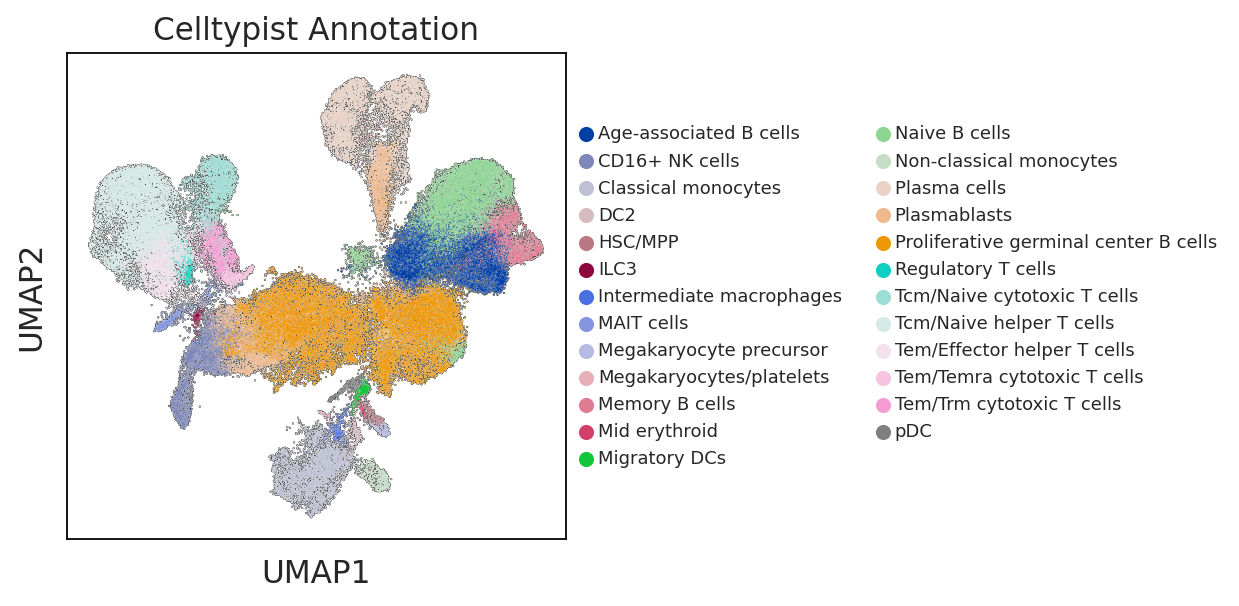

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 33 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'I', 'K', 'L', 'M', 'N', 'P', 'S', 'T', 'U', 'a', 'e', 'eight', 'four', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'six', 'space', 't', 'two', 'u', 'underscore', 'zero']
Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 23, 25, 27, 36, 37, 38, 44, 46, 47, 48, 49, 51, 54, 55, 56, 66, 68, 72, 76, 79, 80, 81, 82, 83, 87, 88]
Closed glyph list over 'GSUB': 33 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'I', 'K', 'L', 'M', 'N', 'P', 'S', 'T', 'U', 'a', 'e', 'eight', 'four', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'six', 'space', 't', 'two', 'u', 'underscore', 'zero']
Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 23, 25, 27, 36, 37, 38, 44, 46, 47, 48, 49, 51, 54, 55, 56, 66, 68, 72, 76, 79, 80, 81, 82, 8

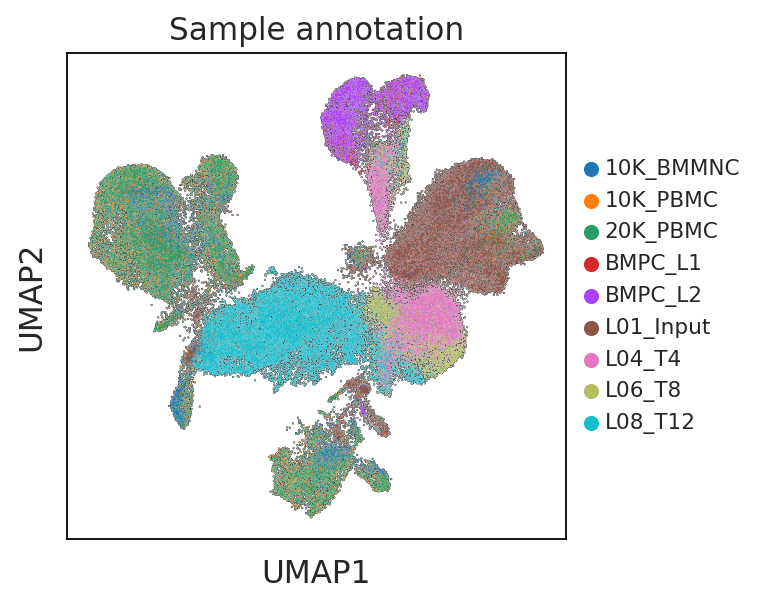

In [18]:
#sc.pl.umap(adata, size= 10, color = anno_1, edges=True, edges_width=0.01)
sc.pl.umap(adata, color=anno_1, frameon=True, 
          title="Celltypist Annotation", add_outline=True, legend_fontoutline=2, legend_fontsize='xx-small', save="_CellType_Annotation")

sc.pl.umap(adata, color="sample_uid", frameon=True,
          title="Sample annotation", add_outline=True, legend_fontoutline=4, legend_fontsize='x-small', save="_sample_uid_Annotation")

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 21 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'S', 'a', 'e', 'five', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'space', 't', 'three', 'two', 'zero']
Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 24, 36, 54, 68, 72, 76, 79, 80, 81, 82, 83, 87]
Closed glyph list over 'GSUB': 21 glyphs after
Glyph names: ['.notdef', '.null', 'A', 'S', 'a', 'e', 'five', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'space', 't', 'three', 'two', 'zero']
Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 22, 24, 36, 54, 68, 72, 76, 79, 80, 81, 82, 83, 87]
Closing glyph list over 'MATH': 21 glyphs before
Glyph names: ['.notdef', '.null', 'A', 'S', 'a', 'e', 'five', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'space', 't', 'three', 'two', 'zero']
G

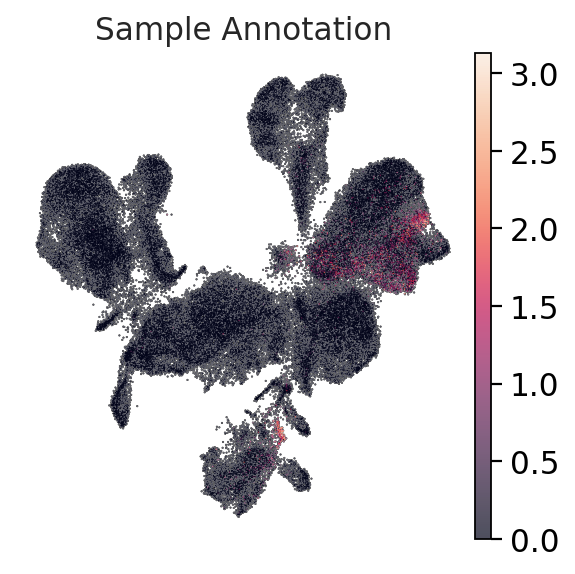

In [19]:
sc.pl.umap(adata, color="CD1C", frameon=False,
          title="Sample Annotation", add_outline=True, legend_fontoutline=4, legend_fontsize='x-small', save="CD1C")

# NK Cell Filtration

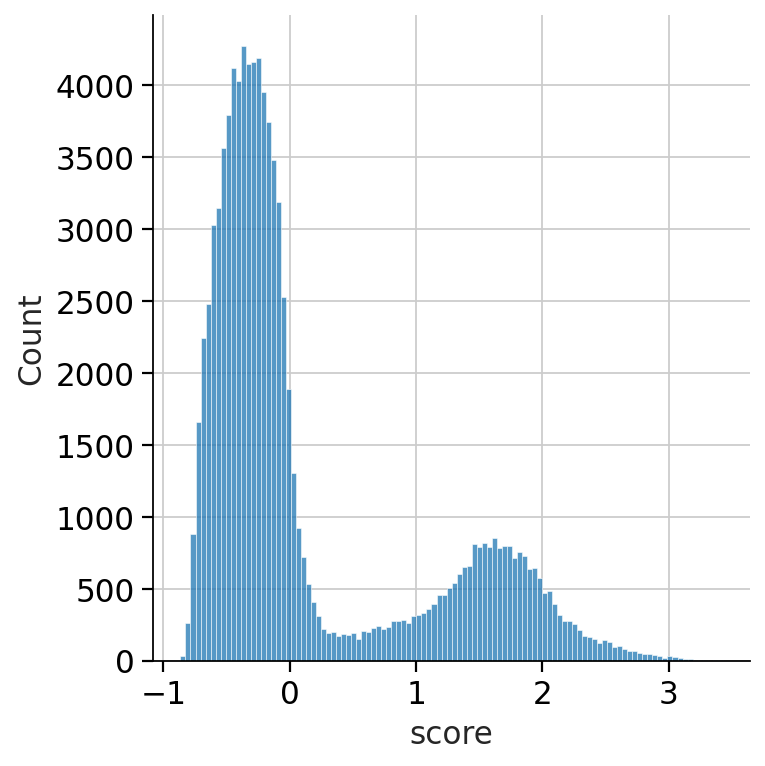

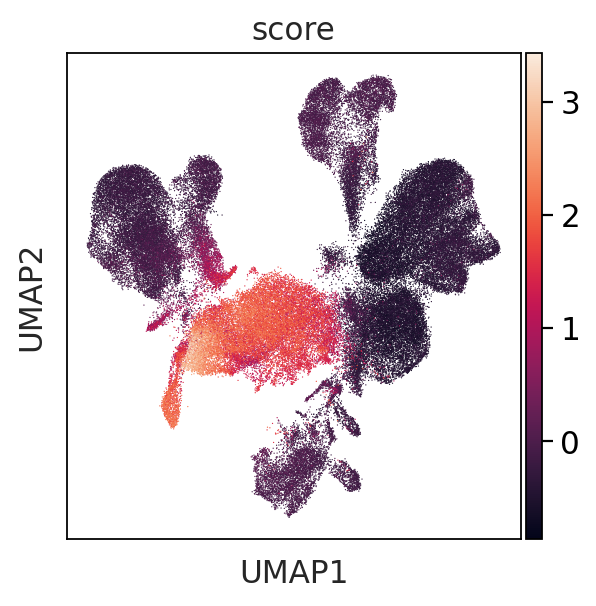

In [20]:
# remove NK Cells which become contaminants downstream and appear to confuse Celltypist
sc.tl.score_genes(adata, gene_list=['NCAM1',
 'GZMB',
 'VIM',
 'NKG7',
 'PRF1',
 'RNF213',
 'GNLY',
 'CTSW',
 'CST7',
 'GZMA'])

sns.displot(adata.obs.score)
sc.pl.umap(adata, color = 'score')

adata = adata[adata.obs.score < 0.1]

maxp pruned
cmap pruned
kern dropped
post pruned
FFTM dropped
GPOS pruned
GSUB pruned
name pruned
glyf pruned
Added gid0 to subset
Added first four glyphs to subset
Closing glyph list over 'GSUB': 31 glyphs before
Glyph names: ['.notdef', '.null', 'B', 'C', 'I', 'K', 'L', 'M', 'N', 'P', 'S', 'T', 'a', 'e', 'eight', 'four', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'six', 'space', 't', 'two', 'u', 'underscore', 'zero']
Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 23, 25, 27, 37, 38, 44, 46, 47, 48, 49, 51, 54, 55, 66, 68, 72, 76, 79, 80, 81, 82, 83, 87, 88]
Closed glyph list over 'GSUB': 31 glyphs after
Glyph names: ['.notdef', '.null', 'B', 'C', 'I', 'K', 'L', 'M', 'N', 'P', 'S', 'T', 'a', 'e', 'eight', 'four', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'six', 'space', 't', 'two', 'u', 'underscore', 'zero']
Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 23, 25, 27, 37, 38, 44, 46, 47, 48, 49, 51, 54, 55, 66, 68, 72, 76, 79, 80, 81, 82, 83, 87, 88]
Closing glyph list over '

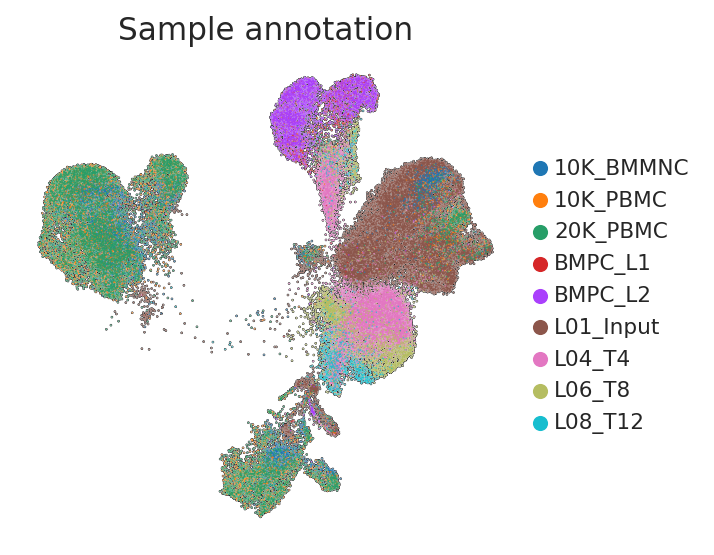

In [21]:
sc.pl.umap(adata, color="sample_uid", frameon=False,
          title="Sample annotation", add_outline=True, legend_fontoutline=4, legend_fontsize='x-small', save="adata_sample_uid_Annotation")

# Annotate The B Cells with Subtypes

In [22]:
bcells = adata[adata.obs[anno_1].str.contains('B cells|Plasma')]
bcells.obs.sample_uid.value_counts()

L01_Input    20403
L04_T4       10103
BMPC_L2       4469
L06_T8        3658
BMPC_L1       1198
L08_T12       1160
20K_PBMC       906
10K_BMMNC      680
10K_PBMC       443
Name: sample_uid, dtype: int64

In [23]:
# Make all IG not a highly variable gene for clustering purposes
bcells.var.loc[bcells.var.index.str.contains("IGH|IGL|IGK"), 'highly_variable'] = False

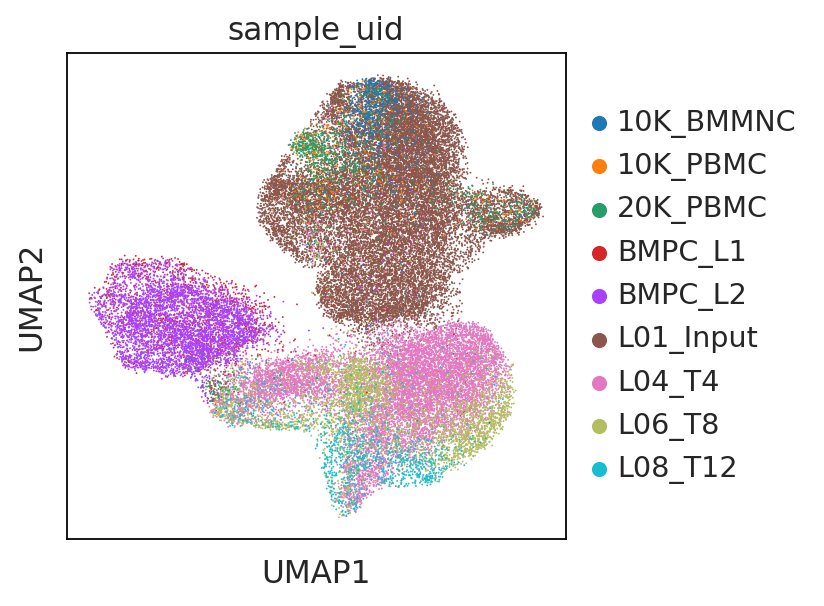

In [24]:
bcells = recluster(bcells, batch_correct=True)

In [25]:
# Celltypist Annotations to bcells object
anno_2 = 'celltypist'
predictions = celltypist.annotate(bcells, model = 'Immune_All_Low.pkl', majority_voting=True)
bcells.obs[anno_2] = predictions.predicted_labels.majority_voting

👀 Detected scaled expression in the input data, will try the `.raw` attribute
🔬 Input data has 43020 cells and 36601 genes
🔗 Matching reference genes in the model
🧬 6147 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!


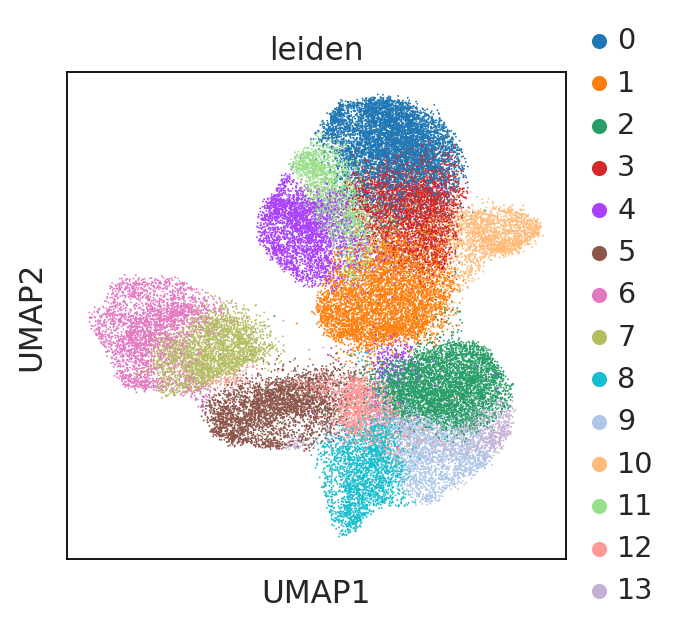

In [26]:
sc.tl.leiden(bcells, resolution=1)
sc.pl.umap(bcells, color = 'leiden')



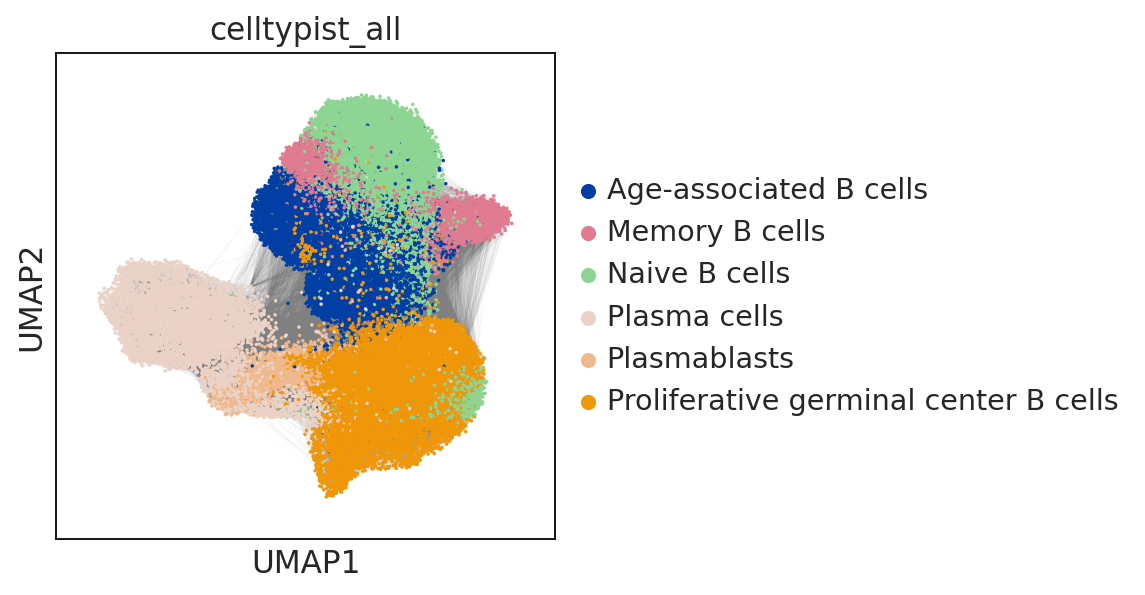

In [27]:
sc.pl.umap(bcells, size= 10, color = anno_1, edges=True, edges_width=0.01)

## Add columns to object for use in creating figures

In [28]:
bcells = bcells[bcells.obs[anno_2].str.contains('B cells|Plasma')]


In [29]:
bcells.obs['isotype_simple'] = bcells.obs.IR_VDJ_1_c_call.map(IGH_simplify())

In [30]:
bcells.obs['fraction_mutated_bases'] = 1-bcells.obs['IR_VDJ_1_v_identity']

In [ ]:
# filtering out low quality B cells
# Filters out some probably artefactual cells
bcells = bcells[bcells.obs.has_ir == 'True']
# Filters out putatively dead / apoptotic B cells
# filter B cells without a Constant Region Call
bcells = bcells[bcells.obs.dropna(subset='IR_VDJ_1_c_call').index, :]

bcells = bcells[bcells.obs.dropna(subset='isotype_simple').index, :]

# filter out weird cells where they have a light chain called as the heavy chain
bcells = bcells[~bcells.obs.IR_VDJ_1_c_call.str.contains("IGK|IGL"),:]
# filter out B cells without mutational information
bcells = bcells[bcells.obs.simple_mutation_status.dropna().index]
#bcells.obs['fraction_mutated_bases'] = 1 - bcells.obs['IR_VDJ_1_v_identity']

bcells.obs['bcelltype'] = bcells.obs['celltypist']
cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(bcells.obs.bcelltype.cat.categories)))
bcells.uns["bcelltype_colors"] = list(map(mpl.colors.to_hex, colors))
bcells.uns["bcelltype_colors_dict"] = dict(zip(bcells.obs.bcelltype.unique().sort_values(), bcells.uns['bcelltype_colors']))
color = 'bcelltype'
palette = bcells.uns[color+'_colors']

bcells.uns['celltype_colors'] = None

bcells.obs['bcelltype'] = bcells.obs.celltypist.str.replace("Age-associated ", "").values

bcells.obs.bcelltype = bcells.obs['bcelltype'].str.replace("germinal center", "GC")
bcells.obs.bcelltype = bcells.obs['bcelltype'].str.replace("Proliferative", "Prolif.")

# combine mutation status and isotype call
bcells.obs['combined_ab'] = bcells.obs['mutation_status'].astype(str) + "_" + bcells.obs['isotype_simple'].astype(str)
bcells.obs['bcelltype_multi'] = bcells.obs['bcelltype'].astype(str) + "_" + bcells.obs['simple_mutation_status'].astype(str) + "_" + bcells.obs['isotype_simple'].astype(str)

bcells.obs['switched'] = bcells.obs.IR_VDJ_1_c_call.map(IGH_switched())

# what's with all the ABCs?

In [ ]:
models.models_description()

model = models.Model.load(model = '/home/michaelswift/.celltypist/data/models/Immune_All_Low.pkl')
top_genes = model.extract_top_markers("Age-associated B cells", 15)
sc.pl.umap(bcells, color = list(top_genes) + ['bcelltype'])
# these genes doen't appear specific, a B cell

In [ ]:
sc.pl.umap(bcells, color = ['ITGAX', 'CD1C', 'CD200', "CXCR5", 'BCL6', 'MALAT1', "AICDA", "MYC", "EBI3", 'sample_id', 'mutation_status'], use_raw = False, size = 12)


In [ ]:
sc.pl.umap(bcells, color = ['ITGAX', 'CD1C', 'CD200', "CXCR5", 'BCL6', 'MALAT1', "CD38", "CCR6",'sample_id', 'mutation_status'], use_raw = True, size = 10)


In [ ]:
bcells.write_h5ad('../../processed_data/h5ad_objects/bcells.12.1.2022.h5ad')